In [1]:
import networkx as nx
import json

import umap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from scipy.linalg import sqrtm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from karateclub import DeepWalk, Node2Vec
from gensim.models.word2vec import Word2Vec
from imblearn.over_sampling import SMOTE

# Source: Andrea Araldo
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat

--2022-02-12 13:24:05--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: 'visualization.py.4'

     0K .......... ..                                         100%  688K=0.02s

2022-02-12 13:24:06 (688 KB/s) - 'visualization.py.4' saved [13008/13008]



In [2]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = 18, 7
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Function to plot Confusion Matrix in values. Source: Nouamane Arhachoui.

In [3]:
# Source: Nouamane Arhachoui
def plot_conf(y_test, y_pred, class_names):
  cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot()
  plt.show()

Function to plot a graph more clearly. Source: Vincent Gauthier.

In [4]:
#Source: Vincent Gauthier
from networkx.drawing.layout import spring_layout

def plot_graph(G, node_color, colormap="RdBu_r", ax=None):
    dpi = 300
    h,w = 2480,3508

    pos = spring_layout(G, weight="weight")
    #pos = spring_layout(G)


    fig = plt.figure(figsize=(w/dpi,h/dpi),dpi=dpi)
    #plt.figure(figsize=(20,11))
    ax = plt.gca()

    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="black")
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=300,
        edgecolors="blue",
        node_color=node_color,
        cmap=colormap,
    )

    nx.draw_networkx_labels(G, pos, font_size=7, font_color="white")

    ax.margins(0.20)
    plt.axis("off")
    plt.show()

# GitHub Dataset

The Dataset was collected from the public API of GitHub in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them. The entire dataset contains 37700 nodes and 289,003
edges.

This notebook performs binary node classification, this is try to predict whether the GitHub user is a web or a machine learning developer, using DeepWalk and Node2Vec algorithms.

Source: https://github.com/benedekrozemberczki/datasets

In [5]:
edges_path = 'Documents\git_web_ml\musae_git_edges.csv'
targets_path = 'Documents\git_web_ml\musae_git_target.csv'
features_path = 'Documents\git_web_ml\musae_git_features.json'

In [6]:
edges = pd.read_csv(edges_path)
display(edges.head())

,id_1,id_2
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


In [7]:
targets = pd.read_csv(targets_path)
targets.index = targets.id
targets.head()

,id,name,ml_target
id,,,
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


In [8]:
with open(features_path) as json_data:
    features = json.load(json_data)

In [9]:
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

100%|██████████| 37700/37700 [00:00<00:00, 48589.15it/s]


Building the graph:

In [10]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")

In [11]:
print('Number of GitHub user nodes: ', len(graph.nodes), ', number of edges: ', len(graph.edges))

Number of GitHub user nodes:  37700 , number of edges:  289003


For visualization purpouse we are going to show the subgraph for node 5 of 100 nodes:

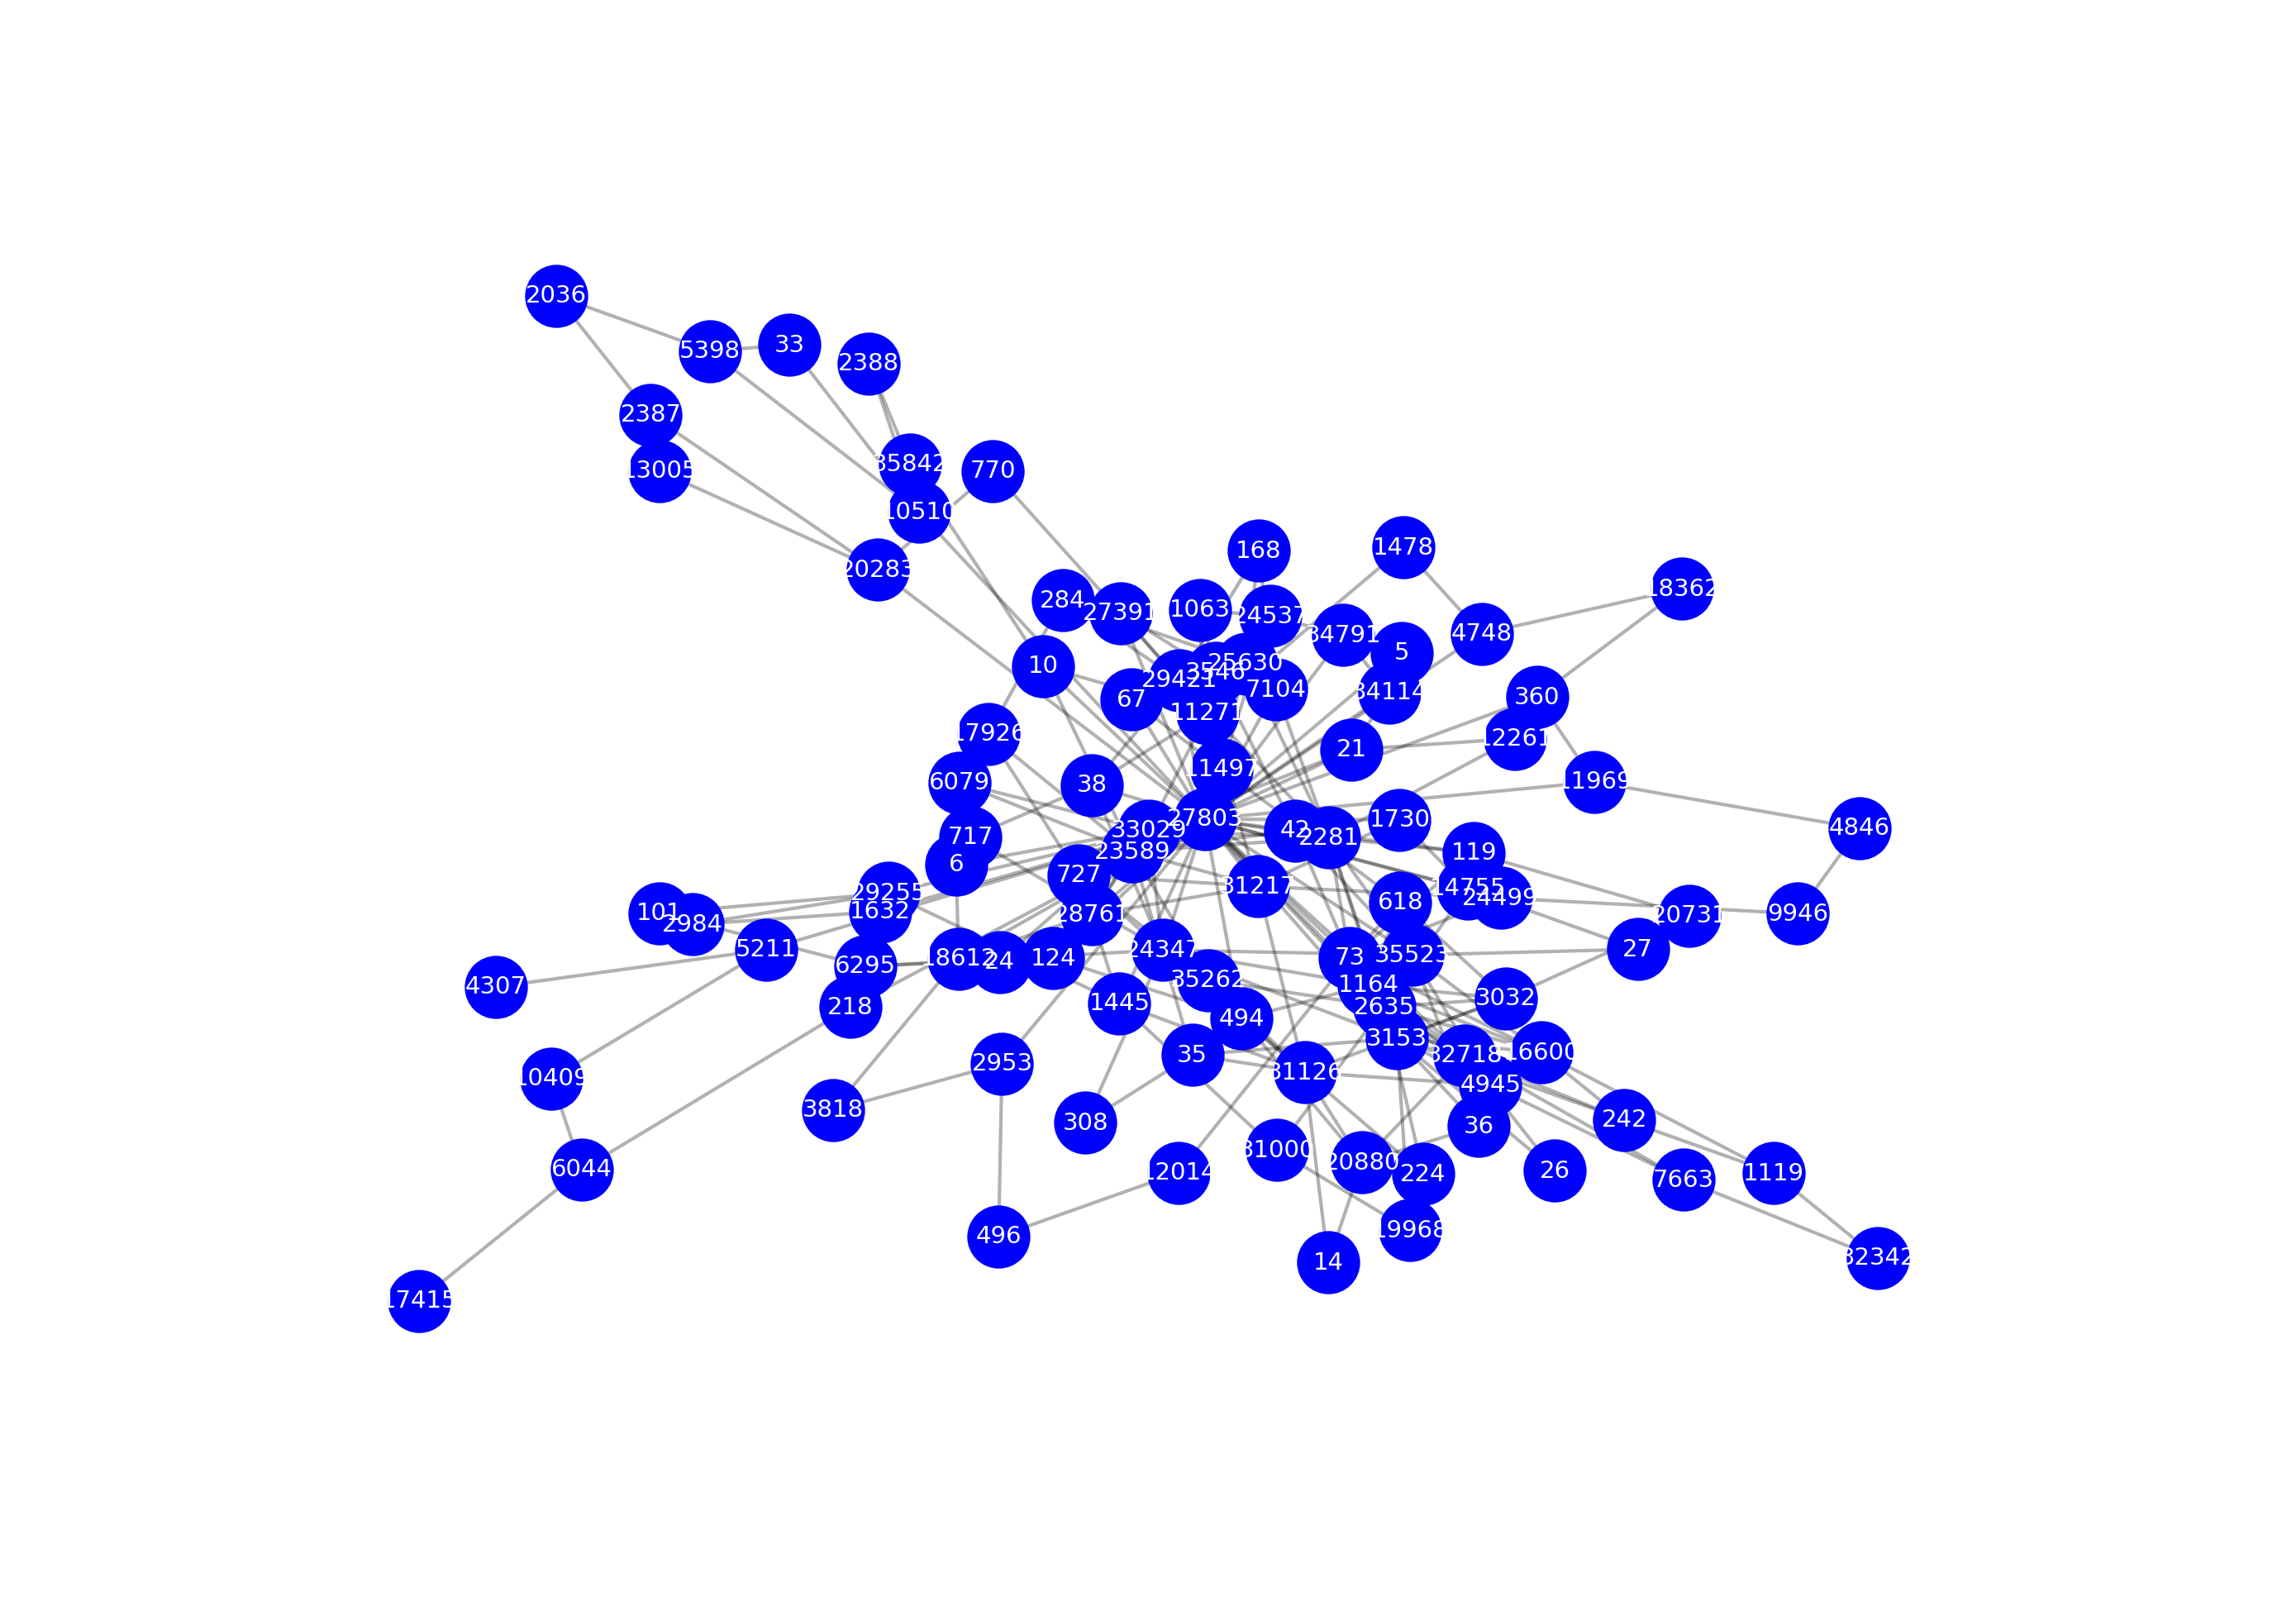

In [12]:
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 5))[:100] #Gets all the nodes in the graph that node 5 belongs to. 
G = graph.subgraph(subgraph_nodes)
plot_graph(G, 'blue')

# DeepWalk

The walk_number parameter is how many random walks we are going to perform per node.

The walk_length parameter is how many steps we are going to perform in each random walk.

In [13]:
# Do random walks
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(graph)

Skip-Gram for DeepWalk: The main idea of the skip-gram model is to predict the context of a sequence from a particular node (or word).

In [14]:
model = Word2Vec(walker.walks,  # previously generated walks
                 hs = 1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size = 128,  # size of the embedding
                 window=10,
                 min_count=1,
                 epochs = 1,
                 workers=4,
                 seed=42)

Embedding for DeepWalk:

In [15]:
# Get the true label
y = targets.loc[[int(i) for i in list(features.keys())], 'ml_target']

In [16]:
X_dw = []
for i in y.index:
    X_dw.append(model.wv.__getitem__(str(i)))

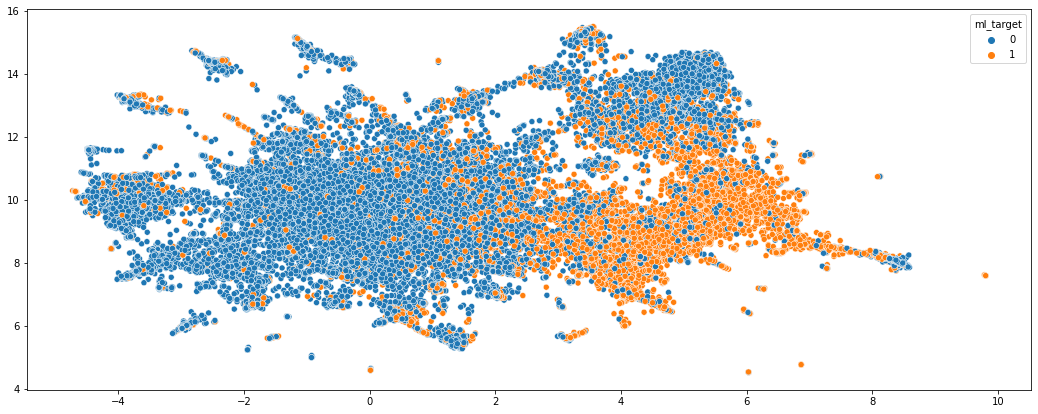

In [17]:
u = umap.UMAP(random_state=42)
dw_umap_embs = u.fit_transform(X_dw)

ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = y)

Training the model:

In [18]:
X_train_dw, X_test_dw, y_train_dw, y_test_dw = train_test_split(X_dw, y, test_size=0.2, random_state=42) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train_dw, y_train_dw)
y_pred_dw = rf.predict(X_test_dw)

print(f1_score(y_test_dw, y_pred_dw, average='micro'))
print(confusion_matrix(y_test_dw, y_pred_dw, normalize='true'))

0.840318302387268
[[0.95914327 0.04085673]
 [0.49243952 0.50756048]]


The following function is used to plot the confusion matrix:

Confusion Matrix for DeepWalk:

Normalized confusion matrix
[[0.95914327 0.04085673]
 [0.49243952 0.50756048]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

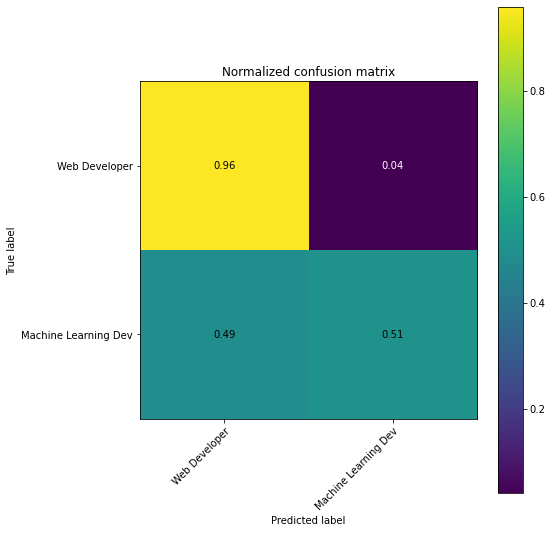

In [19]:
class_names=np.array(['Web Developer', 'Machine Learning Dev'])
plot_conf_mat(y_test_dw, y_pred_dw, class_names)

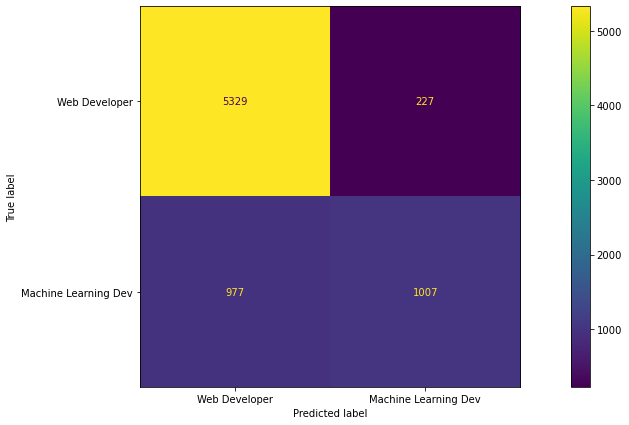

In [20]:
plot_conf(y_test_dw, y_pred_dw, ['Web Developer', 'Machine Learning Dev'])

Balancing the Dataset

In [21]:
smote_dw = SMOTE()
X_train_balanced_dw, y_train_balanced_dw = smote_dw.fit_resample(X_train_dw, y_train_dw)
pd.value_counts(y_train_balanced_dw)

1    22405
0    22405
Name: ml_target, dtype: int64

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train_balanced_dw, y_train_balanced_dw)
y_pred_balanced_dw = rf.predict(X_test_dw)

In [46]:
print(accuracy_score(y_pred_balanced_dw, y_test_dw))
print(f1_score(y_test_dw, y_pred_balanced_dw, average='micro'))

0.8416445623342175
0.8416445623342174


In [40]:
from sklearn.preprocessing import LabelEncoder
y_test_encoder = LabelEncoder()
pred_encoder = LabelEncoder()

In [42]:
y_test_encoder.fit(y_test_dw)
label_train = y_test_encoder.transform(y_test_dw)
y_test_dw = label_train.tolist()

pred_encoder.fit(y_pred_balanced_dw)
label_train = pred_encoder.transform(y_pred_balanced_dw)
y_pred_balanced_dw = label_train.tolist()



Normalized confusion matrix
[[0.92566595 0.07433405]
 [0.39364919 0.60635081]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

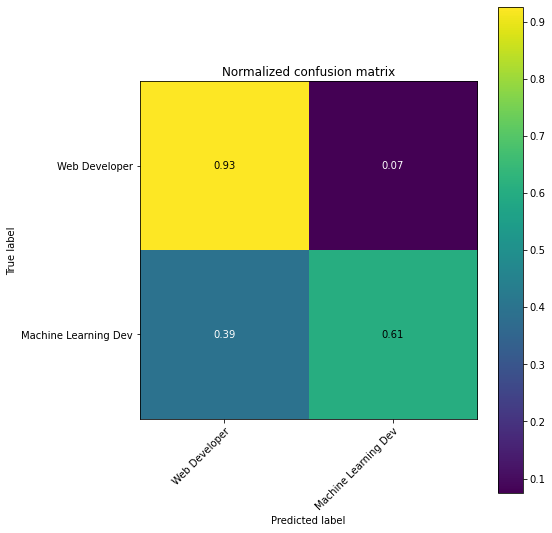

In [43]:
plot_conf_mat(y_test_dw, y_pred_balanced_dw, class_names)

# Node2Vec

The walk_number parameter is how many random walks we are going to perform per node = 80.

The walk_length parameter is how many steps we are going to perform in each random walk = 10.

In [47]:
b_walker = BiasedRandomWalker(80, 10, 0.25, 0.25)
b_walker.do_walks(graph)

Skip-Gram for Node2Vec: The main idea of the skip-gram model is to predict the context of a sequence from a particular node (or word).

In [48]:
node_vec = Word2Vec(b_walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=10,
                 min_count=1,
                 epochs = 1,
                 workers=4,
                 seed=42)

Embedding for DeepWalk:

In [49]:
X_node_vec = []
for i in y.index:
    X_node_vec.append(node_vec.wv.__getitem__(str(i)))

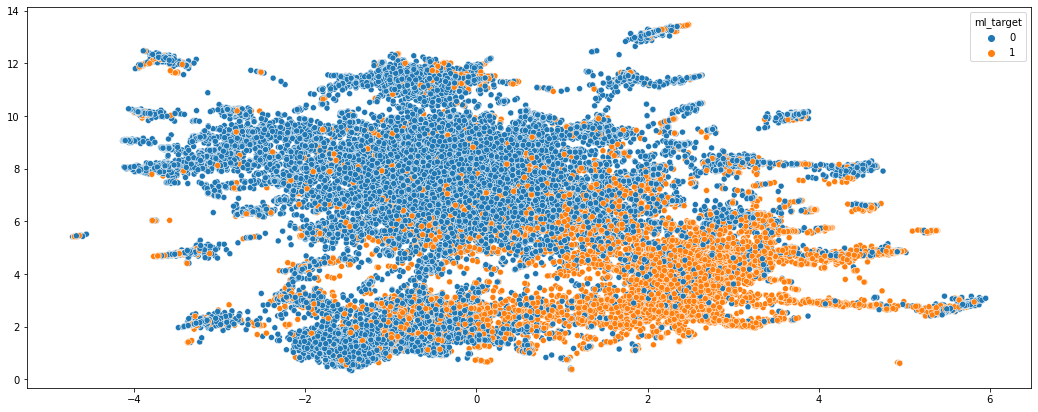

In [50]:
u = umap.UMAP(random_state=42)
nv_umap_embs = u.fit_transform(X_node_vec)

ax = sns.scatterplot(x = nv_umap_embs[:, 0], y = nv_umap_embs[:, 1], hue = y)

Training the model:

In [51]:
X_train_nv, X_test_nv, y_train_nv, y_test_nv = train_test_split(X_node_vec, y, test_size=0.2, random_state=42) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train_nv, y_train_nv)
y_pred_nv = rf.predict(X_test_nv)

print(f1_score(y_test_nv, y_pred_nv, average='micro'))
print(confusion_matrix(y_test_nv, y_pred_nv, normalize='true'))

0.8383289124668435
[[0.96112311 0.03887689]
 [0.50554435 0.49445565]]


Normalized confusion matrix
[[0.96112311 0.03887689]
 [0.50554435 0.49445565]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

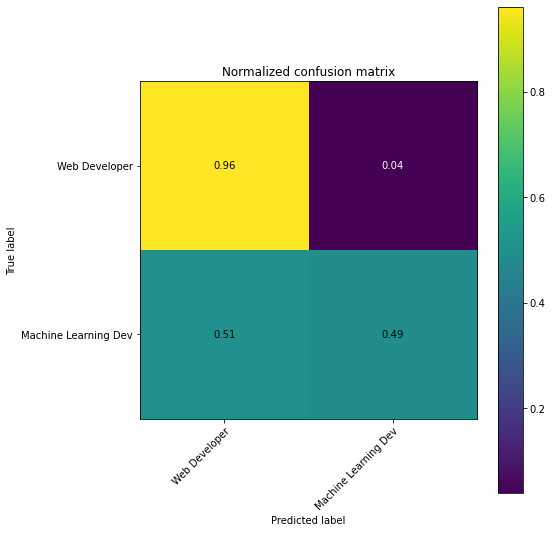

In [52]:
class_names=np.array(['Web Developer', 'Machine Learning Dev'])
plot_conf_mat(y_test_nv, y_pred_nv, class_names)

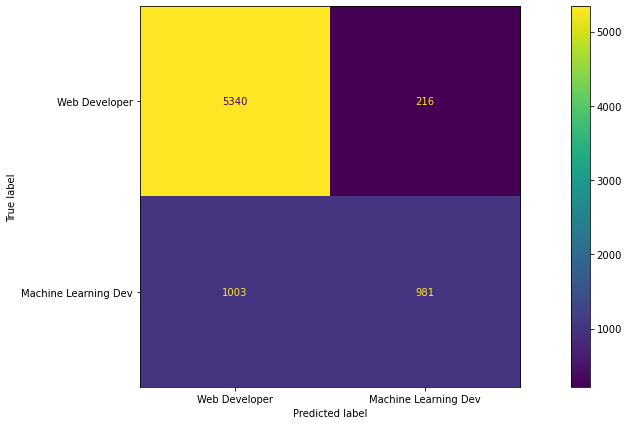

In [53]:
plot_conf(y_test_nv, y_pred_nv, ['Web Developer', 'Machine Learning Dev'])

Balancing the Dataset

In [55]:
smote_nv = SMOTE()
X_train_balanced_nv, y_train_balanced_nv = smote_nv.fit_resample(X_train_nv, y_train_nv)
pd.value_counts(y_train_balanced_nv)

1    22405
0    22405
Name: ml_target, dtype: int64

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train_balanced_nv, y_train_balanced_nv)
y_pred_balanced_nv = rf.predict(X_test_nv)

In [57]:
print(accuracy_score(y_pred_balanced_nv, y_test_nv))
print(f1_score(y_test_nv, y_pred_balanced_nv, average='micro'))

0.8412466843501326
0.8412466843501326


In [58]:
pred_encoder_nv_nv = LabelEncoder()
pred_encoder = LabelEncoder()

In [59]:
pred_encoder_nv_nv.fit(y_test_nv)
label_train = pred_encoder_nv_nv.transform(y_test_nv)
y_test_nv = label_train.tolist()

In [60]:
pred_encoder.fit(y_pred_balanced_nv)
label_train = pred_encoder.transform(y_pred_balanced_nv)
y_pred_balanced_nv = label_train.tolist()

Normalized confusion matrix
[[0.92404608 0.07595392]
 [0.390625   0.609375  ]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

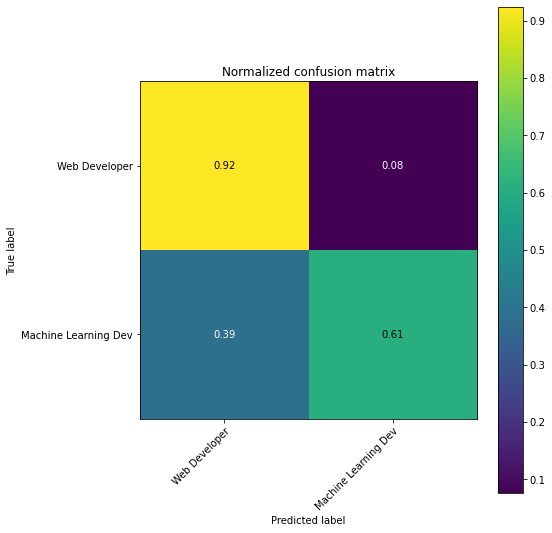

In [61]:
plot_conf_mat(y_test_nv, y_pred_balanced_nv, class_names)

# Comparing F1 Scores

To compare the results of these two algorithms on the Github dataset, we split the dataset into 9 parts and train each part to get the F1 score of each part and compare them.

The F-score, also called the F1-score, is a measure of a model’s accuracy on a dataset.



In [62]:
dw_micro_f1_scores = []
dw_macro_f1_scores = []
for train_size in tqdm(np.arange(0.1, 1, 0.1)):
    X_train, X_test, y_train, y_test = train_test_split(X_dw, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    dw_micro_f1_scores.append(mic)
    dw_macro_f1_scores.append(mac)

100%|██████████| 9/9 [10:00<00:00, 66.72s/it] 


In [63]:
print(dw_micro_f1_scores)

[0.83342175066313, 0.8387267904509284, 0.8411140583554376, 0.8423519009725906, 0.843342175066313, 0.8468832891246686, 0.8478337754199823, 0.8405835543766578, 0.8503978779840848]


In [64]:
nv_micro_f1_scores = []
nv_macro_f1_scores = []
for train_size in tqdm(np.arange(0.1, 1, 0.1)):
    X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    nv_micro_f1_scores.append(mic)
    nv_macro_f1_scores.append(mac)

100%|██████████| 9/9 [10:55<00:00, 72.87s/it] 


In [65]:
print(nv_micro_f1_scores)

[0.8340111995284408, 0.8426061007957559, 0.8418719211822661, 0.8447391688770999, 0.8427055702917772, 0.8497347480106101, 0.8490716180371353, 0.8384615384615386, 0.8437665782493369]


[]

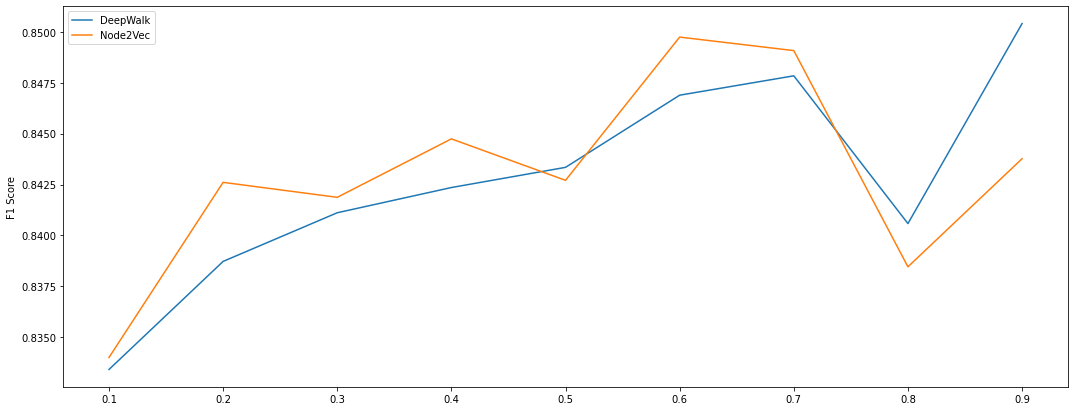

In [66]:
sns.lineplot(x = np.arange(0.1, 1, 0.1), y = dw_micro_f1_scores, label='DeepWalk')
sns.lineplot(x = np.arange(0.1, 1, 0.1), y = nv_micro_f1_scores, label='Node2Vec')
plt.ylabel('F1 Score')
plt.plot()